In [1]:
import pandas as pd
import numpy as np
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Permute,Conv1D, BatchNormalization, GlobalAveragePooling1D, concatenate, Input
from keras.layers import Activation
from keras.layers import Dropout
from keras.models import Model

2024-01-21 05:15:33.030772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-21 05:15:33.030842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-21 05:15:33.064900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-21 05:15:33.138295: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 05:15:34.477009: W tensorflow/compiler/tf2

In [2]:
subjectList = pd.read_csv('participantID1.csv', header=None) # import the number participant IDs without the header
numSubjects = subjectList.count()[0]

subjectAlias = np.linspace(1,numSubjects,numSubjects).tolist()
outerSubjectAlias = subjectAlias
trialNames = ['NN','YN','NY','YY'] # NN = NNL + NNH, YN = YNL + YNH, NY = NYL + NHH, YY = YYL + YYH

In [3]:
pwd

'/mnt/e/PreliminaryAnalysisGrandCanyon/src/inferenceLSTM/newML/metisRun/test1'

In [12]:
import pickle
with open('LSTM_inputData/trajectoryDataFrame_'+str(15)+'_multilabel.pkl', 'rb') as file:
    # Call load method to deserialze
        trajectoryDataFrame = pickle.load(file)
with open('LSTM_inputData/outputDataFrame_'+str(15)+'_multilabel.pkl', 'rb') as file:
# Call load method to deserialze
    outputDataFrame = pickle.load(file)

In [4]:
epochLength = 50
parameterSpace = []
miniBatch = [256, 512]
featureAliases = [0]
#winSize = [5, 10, 15, 20]
# featureCombo = [['xDot','yDot','zDot','thetaDot'], ['speed', 'thetaDot'], ['speed','thetaDot','theta']]
# thetaDot, theta, speed, accel
# speed , thetaDot, height
# how long
featureCombo = [['speed','thetaDot']]
for m in miniBatch:
    for o in featureAliases:
        tempParamSpace = [m,o]
        parameterSpace.append(tempParamSpace)

In [5]:
parameterSpace[0][1]

0

In [6]:
parameterSpace

[[256, 0], [512, 0]]

In [7]:
def assignUserOutput(dataFrameData, requiredSubjects):
    requiredData = dataFrameData.loc[requiredSubjects].to_numpy()
    return requiredData

def assignUserTraj(dataFrameData, requiredSubjects, featureCombo, requiredFeatureCombo):
    requiredData = np.array([])
    for i in range(len(trajectoryDataFrame)):
        temp = dataFrameData[i].loc[requiredSubjects,featureCombo[requiredFeatureCombo]].to_numpy()
        temp = temp.reshape(temp.shape[0],1,temp.shape[1])
        if i == 0:
            requiredData = temp
        if i != 0 :
            requiredData = np.append(requiredData,temp, axis=1)
    return requiredData

In [9]:
# def CNNlstmModel(numFeatures, seqLength, numCLasses, NUM_CELLS=8):

#     #ip = Input(shape=(numFeatures, seqLength))
#     ip = Input(shape=(seqLength, numFeatures))
#     x = Permute((2, 1))(ip)
#     x = LSTM(NUM_CELLS)(x)
#     x = Dropout(0.8)(x)

#     #y = Permute((2, 1))(ip)
#     #y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
#     y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(ip)
#     y = BatchNormalization()(y)
#     y = Activation('relu')(y)

#     y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
#     y = BatchNormalization()(y)
#     y = Activation('relu')(y)

#     y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
#     y = BatchNormalization()(y)
#     y = Activation('relu')(y)

#     y = GlobalAveragePooling1D()(y)

#     x = concatenate([x, y])
#     #out = Dense(numCLasses, activation='softmax')(x)
#     out = Dense(numCLasses, activation='sigmoid')(x)
#     model = Model(ip, out)
#     optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)
#     #model.compile(loss='categorical_crossentropy',optimizer =optimizer,metrics=['accuracy']) 
#     model.compile(loss='BinaryCrossentropy',optimizer =optimizer,metrics=['accuracy']) 
#     # model.summary()
#     #model.summary()
#     # add load model code here to fine-tune
#     return model

In [37]:
def CNNlstmModel(numFeatures, seqLength, numCLasses, NUM_CELLS=8):

    #ip = Input(shape=(numFeatures, seqLength))
    ip = Input(shape=(seqLength, numFeatures))
    x = Permute((2, 1))(ip)
    x = LSTM(NUM_CELLS)(x)
    x = Dropout(0.8)(x)

    #y = Permute((2, 1))(ip)
    #y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = Conv1D(128, 8, padding='same')(ip)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(256, 5, padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(128, 3, padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])
    #out = Dense(numCLasses, activation='softmax')(x)
    out = Dense(numCLasses, activation='sigmoid')(x)
    model = Model(ip, out)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)
    #model.compile(loss='categorical_crossentropy',optimizer =optimizer,metrics=['accuracy']) 
    model.compile(loss='BinaryCrossentropy',optimizer =optimizer,metrics=['accuracy']) 
    # model.summary()
    #model.summary()
    # add load model code here to fine-tune
    return model

In [8]:
def CNNlstmModel(numFeatures, seqLength, numCLasses, NUM_CELLS=8):

    inputs = Input(shape=(seqLength,numFeatures))
    modelLSTM = Permute((2, 1))(inputs)
    modelLSTM = LSTM(NUM_CELLS,return_sequences=False,unroll=True)(modelLSTM)
    modelLSTM = Dropout(0.8)(modelLSTM)

    #lstm2 = LSTM(6, name='LSTM_2')(inputs)
    #modelCNN = Permute((2, 1))(inputs)
    modelCNN = Conv1D(128,8, activation="relu", padding="same")(inputs)
    modelCNN = BatchNormalization()(modelCNN)


    modelCNN = Conv1D(256,5, activation="relu", padding="same")(modelCNN)
    modelCNN = BatchNormalization()(modelCNN)


    modelCNN = Conv1D(128,3, activation="relu", padding="same")(modelCNN)
    modelCNN = BatchNormalization()(modelCNN)
    modelCNN = GlobalAveragePooling1D()(modelCNN)

    concatenated = concatenate([modelLSTM,modelCNN])

    output = Dense(numCLasses,activation='sigmoid')(concatenated)
    
    model = Model(inputs=inputs, outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
    model.compile(loss='binary_crossentropy',optimizer =optimizer,metrics=['accuracy'])
    model.summary()
    return model

In [9]:
trainFraction = 1

In [13]:
numTrainDataInner = int(trainFraction*len(subjectAlias))
numTestDataInner = len(subjectAlias) - numTrainDataInner
trainSubjectsInnerLoop = outerSubjectAlias
testSubjectsInnerLoop = outerSubjectAlias



trainTrajData = assignUserTraj(trajectoryDataFrame,trainSubjectsInnerLoop, featureCombo, 0)
trainOutputData = assignUserOutput(outputDataFrame,trainSubjectsInnerLoop)

testTrajData = assignUserTraj(trajectoryDataFrame,testSubjectsInnerLoop, featureCombo, 0)
testOutputData = assignUserOutput(outputDataFrame,testSubjectsInnerLoop)

In [74]:
trainSubjectsInnerLoop

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0]

In [14]:
features = trainTrajData.shape[2]
seq_length = trainTrajData.shape[1]
numClasses = trainOutputData.shape[1]
mlModel = CNNlstmModel(features, seq_length, numClasses, NUM_CELLS=8)
#mlModel = lstmModel(parameterSpace[k][0], parameterSpace[k][1], parameterSpace[k][2], parameterSpace[k][3], features, seq_length, numClasses)
# print("Parameter Tested: " + str((kk+1)/len(parameterSpace)))
#tf.keras.backend.clear_session()

2024-01-21 05:16:46.673959: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-21 05:16:46.797662: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-21 05:16:46.797996: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-21 05:16:46.799939: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-21 05:16:46.800275: I external/local_xla/xla/stream_executor

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 360, 2)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 360, 128)             2176      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 360, 128)             512       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_1 (Conv1D)           (None, 360, 256)             164096    ['batch_normalization[0][0

In [15]:
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.65 and epoch >= 50):   
          print("Early Stopping, Threshold Reached")   
          self.model.stop_training = True

In [16]:
callbacks = myCallback()
innerHistory = mlModel.fit(trainTrajData,trainOutputData,epochs=300, callbacks=[callbacks],batch_size=512,validation_data=(testTrajData, testOutputData),verbose=1)

Epoch 1/300


2024-01-21 05:17:06.551077: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-21 05:17:08.436781: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-21 05:17:11.225831: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fec001bd9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-21 05:17:11.225883: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-01-21 05:17:11.237461: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705835831.333073    1789 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-01-21 05:17:12.354819: W ext

6/6 [==============================] - 24s 2s/step - loss: 1.1078 - accuracy: 0.4214 - val_loss: 241.4264 - val_accuracy: 0.3189
Epoch 2/300
6/6 [==============================] - 1s 209ms/step - loss: 0.7603 - accuracy: 0.4007 - val_loss: 103.2629 - val_accuracy: 0.6950
Epoch 3/300
6/6 [==============================] - 1s 210ms/step - loss: 0.7138 - accuracy: 0.4234 - val_loss: 22.5961 - val_accuracy: 0.6950
Epoch 4/300
6/6 [==============================] - 1s 209ms/step - loss: 0.6971 - accuracy: 0.3747 - val_loss: 11.7183 - val_accuracy: 0.6950
Epoch 5/300
6/6 [==============================] - 1s 209ms/step - loss: 0.6945 - accuracy: 0.3493 - val_loss: 5.6885 - val_accuracy: 0.3980
Epoch 6/300
6/6 [==============================] - 1s 209ms/step - loss: 0.6837 - accuracy: 0.3568 - val_loss: 7.5091 - val_accuracy: 0.4748
Epoch 7/300
6/6 [==============================] - 1s 208ms/step - loss: 0.6854 - accuracy: 0.4058 - val_loss: 5.2237 - val_accuracy: 0.6053
Epoch 8/300
6/6 [====

In [17]:
mlModel.save('CNN_LSTM_trainedModel', overwrite=True)

INFO:tensorflow:Assets written to: CNN_LSTM_trainedModel/assets


INFO:tensorflow:Assets written to: CNN_LSTM_trainedModel/assets


In [17]:
tf.saved_model.save(mlModel, 'CNN_LSTM_trainedModel')

INFO:tensorflow:Assets written to: CNN_LSTM_trainedModel/assets


INFO:tensorflow:Assets written to: CNN_LSTM_trainedModel/assets


In [18]:
tf.version.VERSION

'2.15.0'

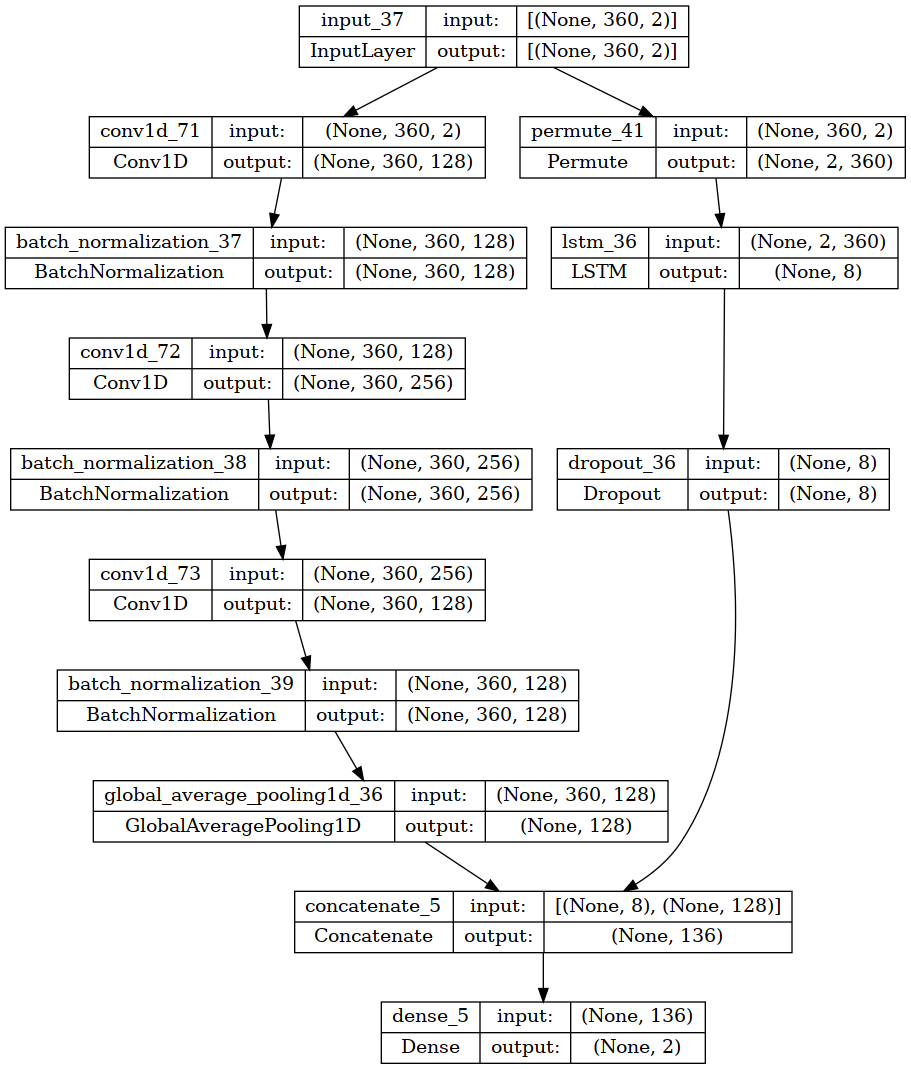

In [116]:
tf.keras.utils.plot_model(mlModel, to_file="my_first_model.png", show_shapes=True, show_layer_names=True)
